In [2]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import dask
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
from scipy.interpolate import griddata # Other package for regridding
# Import some extra functions from utils folder
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
seasons = ['Annual','DJF','MAM','JJA','SON']
root_data_path = '/data/mmenegoz/daily/' # local, first test for only one year
save_data = '/data/mmenegoz/use_case_cci_snow'

In [4]:
%%time
# First test over the Alps for one year
period = slice('2001-01-01','2001-12-31')
# Alpine domain
latlim_ext,lonlim_ext=slice(44,48), slice(5,17)
# the data is extracted only the first time
from pathlib import Path
path = Path(save_data+'/Alpine_snow_2001.nc')
if path.is_file():
    print(f'The file {path} already exists')
    ds_alps = xr.open_mfdataset(save_data+'/Alpine_snow_2001.nc', parallel=True)#, chunks={'time': -1, 'lat': 80, 'lon': 240})
else:
    print(f'The file {path} does not exist')
    print(f'Extracting the data')
    # Parallelization?
    ds = xr.open_mfdataset(root_data_path+'*/*.nc', parallel=True)#, chunks={'time': -1, 'lat': 3600, 'lon': 7200})
    ds_alps=ds.sel(lat=latlim_ext, lon=lonlim_ext,time=period)
    ds_alps.to_netcdf(save_data+'/Alpine_snow_2001.nc')

The file /data/mmenegoz/use_case_cci_snow/Alpine_snow_2001.nc already exists
CPU times: user 13.9 ms, sys: 4.42 ms, total: 18.3 ms
Wall time: 67.7 ms


In [5]:
ds_alps

<xarray.Dataset>
Dimensions:          (lat: 80, lon: 240, time: 365)
Coordinates:
  * lon              (lon) float64 5.025 5.075 5.125 5.175 ... 16.88 16.93 16.98
  * lat              (lat) float64 44.02 44.08 44.12 44.17 ... 47.88 47.92 47.98
  * time             (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
Data variables:
    scfg_interp      (time, lat, lon) float64 dask.array<chunksize=(365, 80, 240), meta=np.ndarray>
    coverage         (time, lat, lon) int64 dask.array<chunksize=(365, 80, 240), meta=np.ndarray>
    coverage_interp  (time, lat, lon) int64 dask.array<chunksize=(365, 80, 240), meta=np.ndarray>
    mask_ice         (time, lat, lon) float32 dask.array<chunksize=(365, 80, 240), meta=np.ndarray>
    mask_water       (time, lat, lon) float32 dask.array<chunksize=(365, 80, 240), meta=np.ndarray>
Attributes:
    processed:                  A linear interpolation on the time dimension ...
    title:                      ESA CCI snow on ground product level L3C dail...
    institution:                Remote Sensing Research Group, Institute of G...
    source:                     AVHRR_NOAA-7_GAC mosaic from ESA Cloud CCI pr...
    date_created:               20211109T162200Z
    history:                    20211109T162200Z: ESA snow_cci SCF processing...
    references:                 http://snow-cci.enveo.at/
    tracking_id:                afb79860-80e9-43f0-9a4c-d798cc7845d5
    Conventions:                CF-1.9
    product_version:            2.0
    format_version:             CCI Data Standards v2.3
    summary:                    The SCFG product provides daily information o...
    keywords:                   snow, cover, AVHRR
    id:                         19820101-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv...
    naming_authority:           ch.unibe
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    cdm_data_type:              Grid
    comment:                    The following auxiliary data sets are used fo...
    creator_name:               Remote Sensing Research Group
    creator_url:                http://giub.unibe.ch
    creator_email:              snow_CCI_AVHRR@giub.unibe.ch
    project:                    Climate Change Initiative - European Space Ag...
    geospatial_lat_min:         -90
    geospatial_lat_max:         90
    geospatial_lon_min:         -180
    geospatial_lon_max:         180
    geospatial_vertical_min:    0
    geospatial_vertical_max:    0
    geospatial_lon_resolution:  0.05
    geospatial_lat_resolution:  0.05
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    time_coverage_start:        19820101T000000Z
    time_coverage_end:          19820101T235959Z
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    standard_name_vocabulary:   CF Standard Name Table v78
    license:                    ESA CCI Data Policy: free and open access
    platform:                   NOAA-7
    sensor:                     AVHRR
    spatial_resolution:         0.05 degree
    key_variables:              scfg
    doi:                        10.5285/3f034f4a08854eb59d58e1fa92d207b6

In [41]:
time_extract='2001-03-01'
ds_alps_check=ds_alps.sel(time=time_extract)

In [42]:
cmap='Blues'
cmap_cov='Reds'
levels=plot.arange(0,100,10)
levels_coverage=plot.arange(0,31,1)

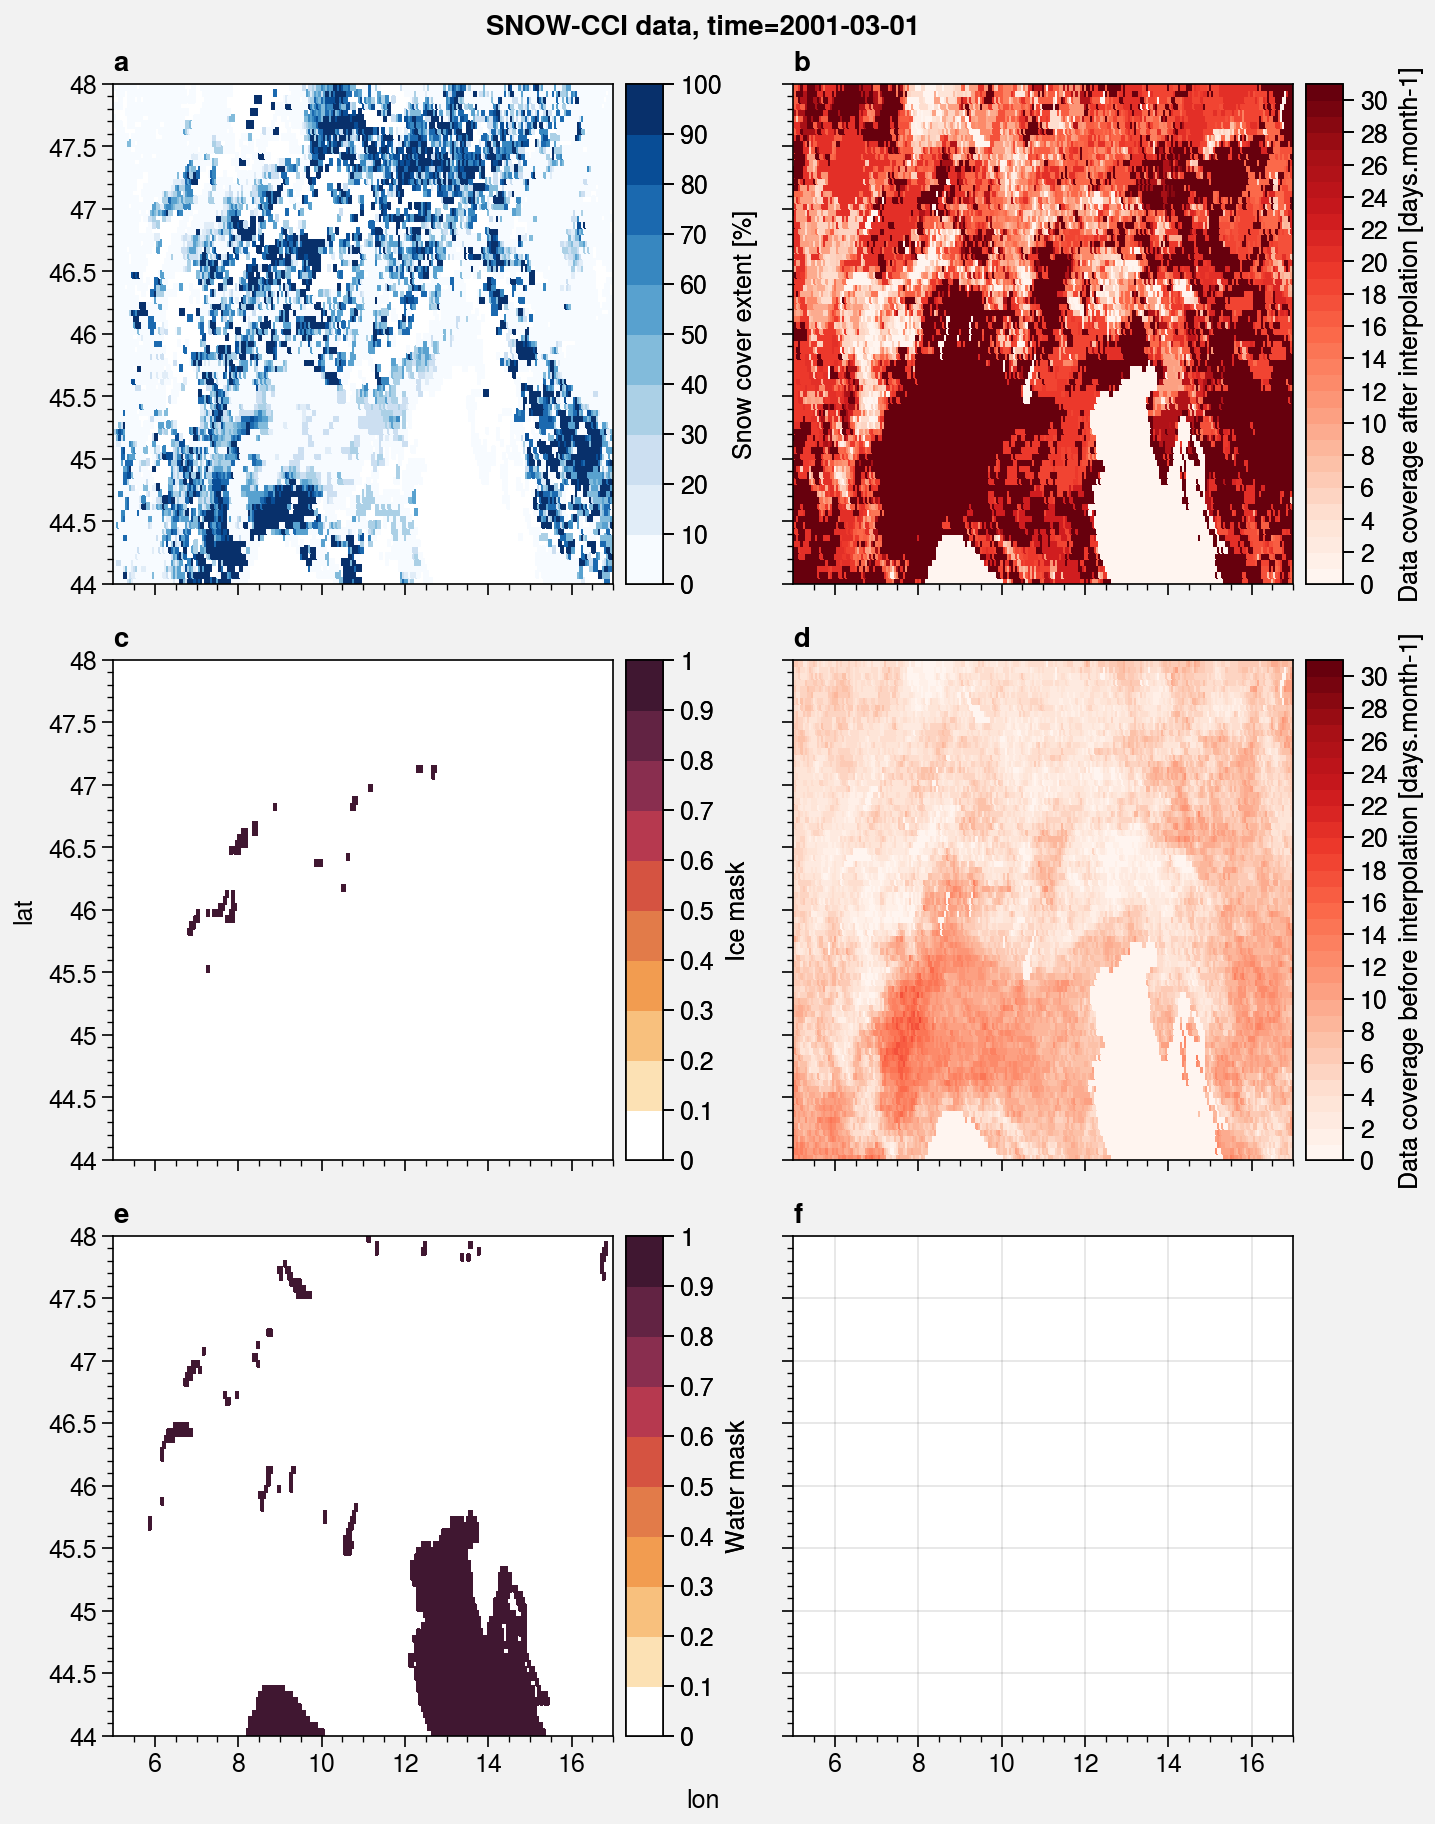

In [48]:
fig,axs = plot.subplots(nrows=3, ncols=2)
axs[0,0].pcolormesh(ds_alps_check.scfg_interp, levels=levels, colorbar='r', cmap=cmap, colorbar_kw={'label': 'Snow cover extent [%]'})
axs[0,1].pcolormesh(ds_alps_check.coverage_interp, levels=levels_coverage, colorbar='r',cmap=cmap_cov, colorbar_kw={'label': 'Data coverage after interpolation [days.month-1]'})
axs[1,1].pcolormesh(ds_alps_check.coverage, levels=levels_coverage, colorbar='r',cmap=cmap_cov, colorbar_kw={'label': 'Data coverage before interpolation [days.month-1]'})
axs[1,0].pcolormesh(ds_alps_check.mask_ice, colorbar='r',colorbar_kw={'label': 'Ice mask'})
axs[1,2].pcolormesh(ds_alps_check.mask_water, colorbar='r',colorbar_kw={'label': 'Water mask'})
axs.format(
    suptitle='SNOW-CCI data, time='+time_extract,
    abc=True
)

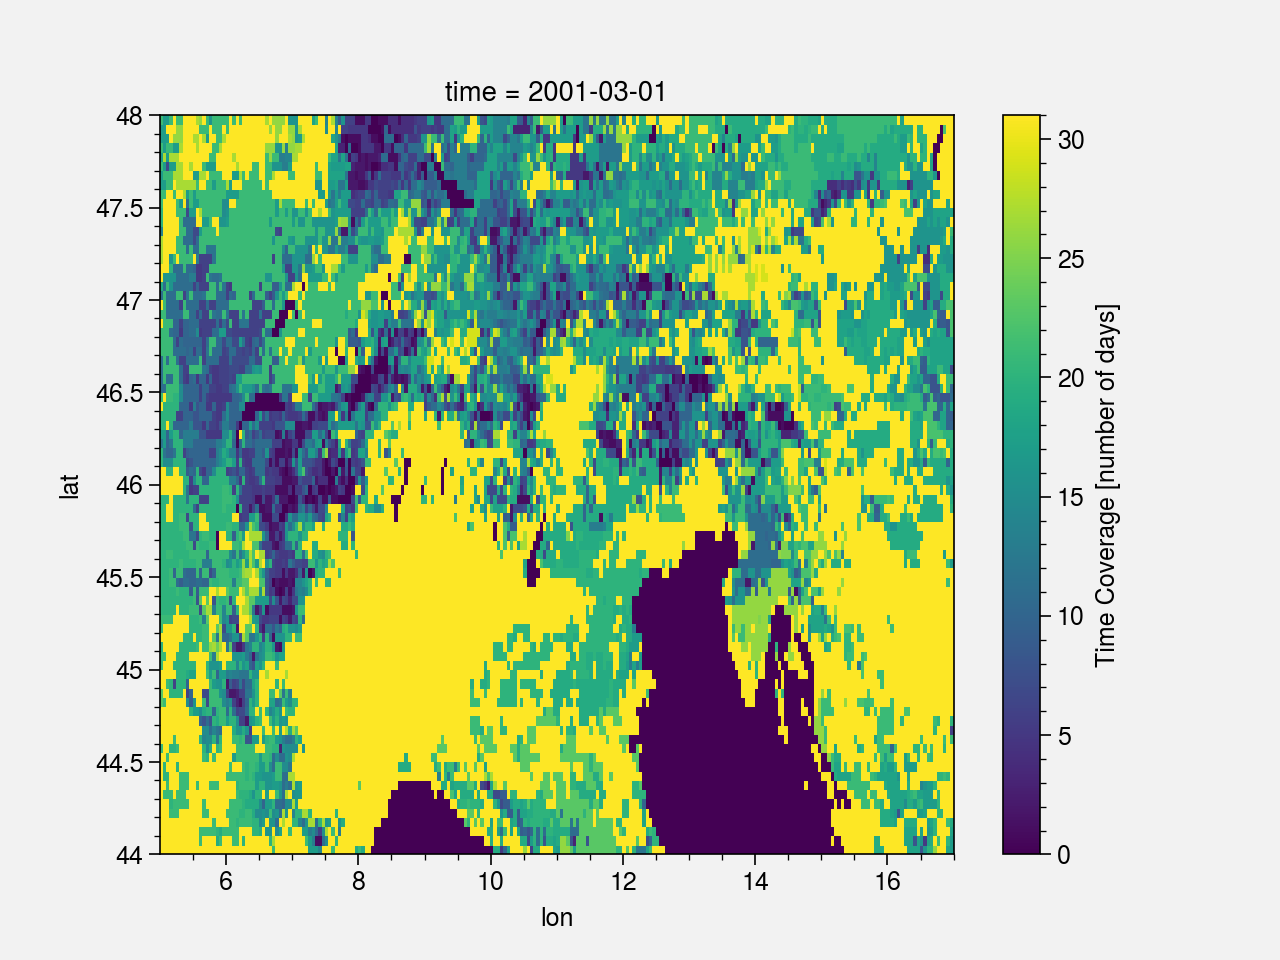

In [15]:
ds_alps_check.coverage_interp.plot()

In [ ]:
# Snow cover duration: to be done!
# SCD=

Topography

In [140]:
# Alpine domain
latlim_ext_topo,lonlim_ext_topo=slice(44,48), slice(5,17)

In [141]:
ds_topo = xr.open_dataset('/data/mmenegoz/GMTED2010/GMTED2010_15n015_00625deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext_topo, lon=lonlim_ext_topo)
elevation = ds_topo.elevation
elevation_std = ds_topo.elevation_stddev


In [143]:
ds_topo

<xarray.Dataset>
Dimensions:           (lat: 64, lon: 192)
Coordinates:
  * lat               (lat) float32 44.03125 44.09375 ... 47.90625 47.96875
  * lon               (lon) float32 5.03125 5.09375 ... 16.90625 16.96875
Data variables:
    elevation         (lat, lon) int16 70 136 227 321 596 ... 171 160 171 159
    elevation_stddev  (lat, lon) int16 15 28 56 66 112 66 92 ... 78 58 48 26 3 8
    elevation_max     (lat, lon) int16 103 218 402 517 849 ... 278 242 180 172
    elevation_min     (lat, lon) int16 41 89 149 215 353 ... 116 112 112 163 140
Attributes:
    institution:                KNMI / TEMIS
    url:                        http://temis.nl/data/gmted2010/
    Title:                      GMTED2010 elevation data regridded at 0.062 d...
    resolution_degrees:         0.0625
    resolution_summing_factor:  15
    input_file:                 S5P_OPER_REF_DEM_15_00000000T000000_99999999T...
    input_correction:           incorrect zero elevation values in the Caspia...
    input_note:                 see "Original_attributes" for a copy of the a...
    creation_date:              2019-10-15
    gmted2010_citation:         Danielson, J.J., and Gesch, D.B., 2011, Globa...
    gmted2010_citation_url:     http://pubs.usgs.gov/of/2011/1073/pdf/of2011-...
    gmted2010_viewer_url:       http://topotools.cr.usgs.gov/gmted_viewer/
    history:                    2016-01-11: Conversion from HDF-5 by Maarten ...

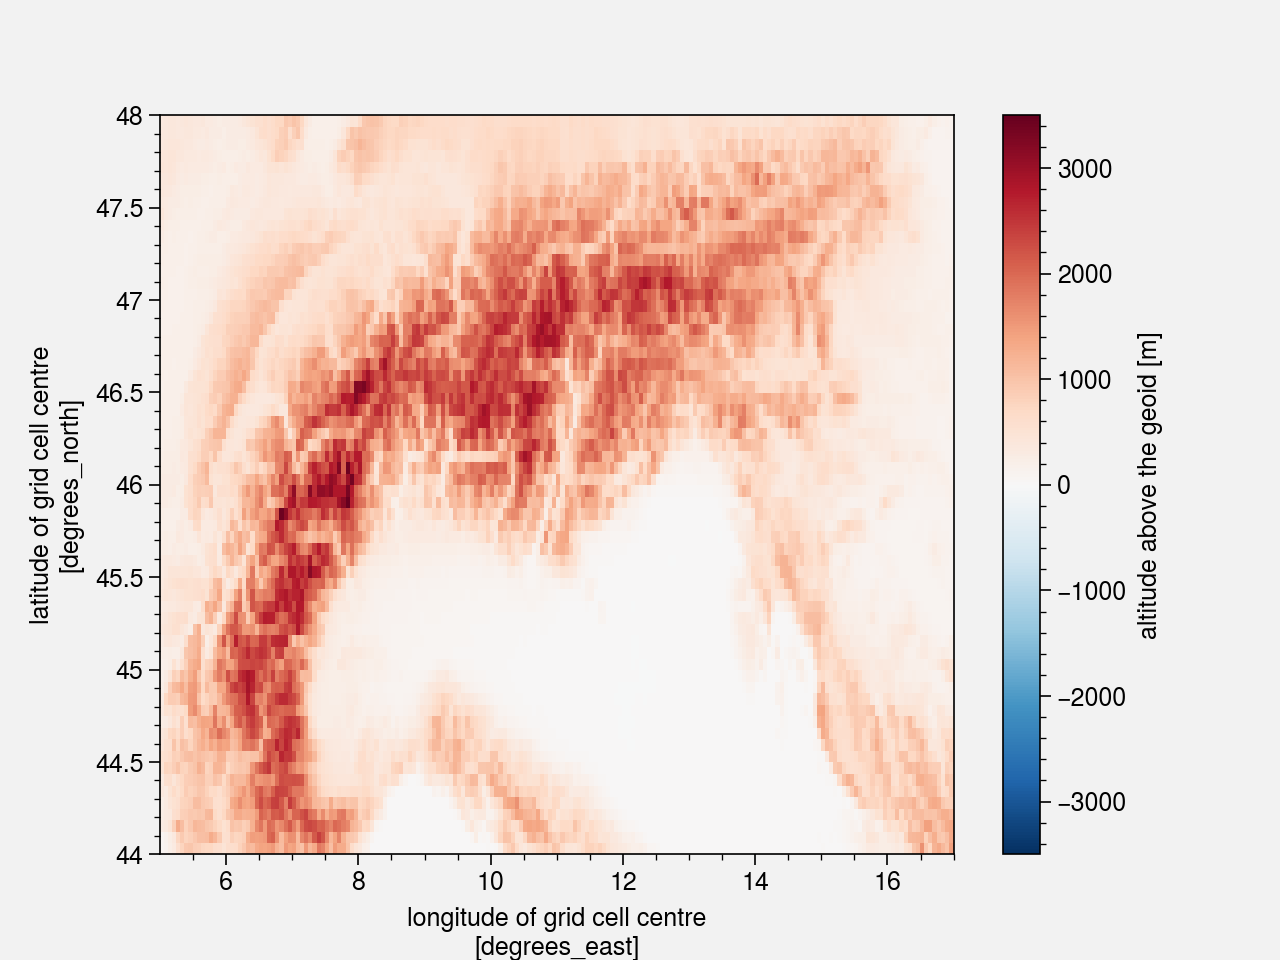

In [144]:
elevation.plot()

In [145]:
ds_alps.lon

<xarray.DataArray 'lon' (lon: 240)>
array([ 5.025,  5.075,  5.125, ..., 16.875, 16.925, 16.975])
Coordinates:
  * lon      (lon) float64 5.025 5.075 5.125 5.175 ... 16.82 16.88 16.93 16.98

In [146]:
ds_topo.lon

<xarray.DataArray 'lon' (lon: 192)>
array([ 5.03125,  5.09375,  5.15625,  5.21875,  5.28125,  5.34375,  5.40625,
        5.46875,  5.53125,  5.59375,  5.65625,  5.71875,  5.78125,  5.84375,
        5.90625,  5.96875,  6.03125,  6.09375,  6.15625,  6.21875,  6.28125,
        6.34375,  6.40625,  6.46875,  6.53125,  6.59375,  6.65625,  6.71875,
        6.78125,  6.84375,  6.90625,  6.96875,  7.03125,  7.09375,  7.15625,
        7.21875,  7.28125,  7.34375,  7.40625,  7.46875,  7.53125,  7.59375,
        7.65625,  7.71875,  7.78125,  7.84375,  7.90625,  7.96875,  8.03125,
        8.09375,  8.15625,  8.21875,  8.28125,  8.34375,  8.40625,  8.46875,
        8.53125,  8.59375,  8.65625,  8.71875,  8.78125,  8.84375,  8.90625,
        8.96875,  9.03125,  9.09375,  9.15625,  9.21875,  9.28125,  9.34375,
        9.40625,  9.46875,  9.53125,  9.59375,  9.65625,  9.71875,  9.78125,
        9.84375,  9.90625,  9.96875, 10.03125, 10.09375, 10.15625, 10.21875,
       10.28125, 10.34375, 10.40625, 10.46875, 10.53125, 10.59375, 10.65625,
       10.71875, 10.78125, 10.84375, 10.90625, 10.96875, 11.03125, 11.09375,
       11.15625, 11.21875, 11.28125, 11.34375, 11.40625, 11.46875, 11.53125,
       11.59375, 11.65625, 11.71875, 11.78125, 11.84375, 11.90625, 11.96875,
       12.03125, 12.09375, 12.15625, 12.21875, 12.28125, 12.34375, 12.40625,
       12.46875, 12.53125, 12.59375, 12.65625, 12.71875, 12.78125, 12.84375,
       12.90625, 12.96875, 13.03125, 13.09375, 13.15625, 13.21875, 13.28125,
       13.34375, 13.40625, 13.46875, 13.53125, 13.59375, 13.65625, 13.71875,
       13.78125, 13.84375, 13.90625, 13.96875, 14.03125, 14.09375, 14.15625,
       14.21875, 14.28125, 14.34375, 14.40625, 14.46875, 14.53125, 14.59375,
       14.65625, 14.71875, 14.78125, 14.84375, 14.90625, 14.96875, 15.03125,
       15.09375, 15.15625, 15.21875, 15.28125, 15.34375, 15.40625, 15.46875,
       15.53125, 15.59375, 15.65625, 15.71875, 15.78125, 15.84375, 15.90625,
       15.96875, 16.03125, 16.09375, 16.15625, 16.21875, 16.28125, 16.34375,
       16.40625, 16.46875, 16.53125, 16.59375, 16.65625, 16.71875, 16.78125,
       16.84375, 16.90625, 16.96875], dtype=float32)
Coordinates:
  * lon      (lon) float32 5.03125 5.09375 5.15625 ... 16.90625 16.96875
Attributes:
    long_name:  longitude of grid cell centre
    units:      degrees_east
    axis:       X
    bounds:     longitude_bounds

In [147]:
grid_x, grid_y = np.meshgrid(ds_alps.lat, ds_alps.lon)

In [148]:
np.min(ds_topo.lat), np.max(ds_topo.lat)

(<xarray.DataArray 'lat' ()>
 array(44.03125),
 <xarray.DataArray 'lat' ()>
 array(47.96875))

In [149]:
ds_topo.lat.shape, ds_topo.lon.shape, ds_topo.elevation.shape, grid_x.shape, grid_y.shape

((64,), (192,), (64, 192), (240, 80), (240, 80))

In [160]:
from scipy.interpolate import interpn
elevation_interp = interpn((ds_topo.lat,ds_topo.lon), ds_topo.elevation, (grid_y, grid_x))

ValueError: One of the requested xi is out of bounds in dimension 0

In [152]:
def value_func_3d(x, y, z):

    return 2 * x + 3 * y - z

x = np.linspace(0, 4, 5)

y = np.linspace(0, 5, 6)

z = np.linspace(0, 6, 7)

points = (x, y, z)

values = value_func_3d(*np.meshgrid(*points, indexing='ij'))

In [153]:
point = np.array([2.21, 3.12, 1.15])

print(interpn(points, values, point))

[12.63]


In [156]:
x.shape, y.shape, z.shape, values.shape, point.shape

((5,), (6,), (7,), (5, 6, 7), (3,))